In [1]:
from IPython.display import clear_output

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [3]:
assert torch.cuda.is_available()
cuda = torch.device('cuda')

In [21]:
# Handcrafted data domain specified by corners
x_start = 1.0
x_end = 5.5
y_start = -1.5
y_end = 1.5
corners = [x_start, x_end, y_start, y_end]

# Handcrafted reference points
x0 = [3.8, 0.9]
x1 = [2.7, 0.361]
x2 = [5.025, 0.9]  # [4.94, 0.452]
xtil = [1.4, -0.276]
reference_points = [x0, x1, x2, xtil]

# stale line from x0 to xtil
# x7 = np.linspace(1.4,3.8,10)
# y7 = 0.49*x7 - 0.962

In [15]:
np.sqrt((3.8-2.7)**2 + (0.9-0.361)**2)

1.2249575502849066

In [20]:
np.sqrt((5.025-3.8)**2 + (0.9-0.9)**2)

1.2250000000000005

In [5]:
# Handcrafter classifiers 
def h_star_bnd(t : torch.Tensor):
    return torch.sin(t+0.5)

def h_star(t: torch.Tensor):
    assert len(t.shape) == 2 # shape is batch x inp_dimensions 
    assert t.shape[1] == 2
    out = torch.zeros_like(t)
    
    for index in range(t.shape[0]):
        out[index][0] = h_star_bnd(t[index][0])
        out[index][1] = t[index][1] 

    return out 

def h_1_bnd(t: torch.Tensor):
    return torch.sin(t+0.5)  - 0.75*torch.cos(t+0.5) - 0.2*torch.sin(3*(t+0.5)) - 0.1 

def h_1(t: torch.Tensor):
    assert len(t.shape) == 2 # shape is batch x inp_dimensions 
    assert t.shape[1] == 2
    out = torch.zeros_like(t)
    
    for index in range(t.shape[0]):
        out[index][0] = h_1_bnd(t[index][0])
        out[index][1] = t[index][1] 

    return out 


def h_2_bnd(t: torch.Tensor):
    return torch.sin(t+0.5) + 0.07*torch.sin(5*(t+0.5)) + 0.15*((t+0.5)**2) - 0.49*(t+0.5) + 0.2 - 1*(F.relu(t-4.3))**2

def h_2(t: torch.Tensor):
    assert len(t.shape) == 2 # shape is batch x inp_dimensions 
    assert t.shape[1] == 2
    out = torch.zeros_like(t)
    
    for index in range(t.shape[0]):
        out[index][0] = h_2_bnd(t[index][0])
        out[index][1] = t[index][1] 

    return out   

def predict_label(classifier, input):
    dim_flag = False 
    if input.dim() == 1:
        input = input.unsqueeze(0)
        dim_flag = True 
    out = classifier(input)
    labels = torch.argmax(out, dim=1)
    if dim_flag:
        return labels[0].item()
    else: 
        return labels 

In [6]:
# only needed for plotting so returning numpy arrays
def generate_decision_boundary(corners):
    x_start, x_end = corners[0], corners[1]
    x = torch.linspace(x_start,x_end,100)
    y_star = h_star_bnd(x).detach().cpu()
    y_1 = h_1_bnd(x).detach().cpu()
    y_2 = h_2_bnd(x).detach().cpu()
    return x.numpy(), y_star.numpy(), y_1.numpy(), y_2.numpy()


def generate_data_domain(corners):
    x_start, x_end, y_start, y_end = corners[0], corners[1], corners[2], corners[3]
    x_left = np.ones(1000)*x_start
    y_left = np.linspace(y_start,y_end,1000)

    x_right = torch.ones(1000)*x_end
    y_right = np.linspace(y_start,y_end,1000)

    x_down = np.linspace(x_start,x_end,100)
    y_down = np.ones(100)*y_start

    x_up = np.linspace(x_start,x_end,100)
    y_up = np.ones(100)*y_end

    return x_left, y_left, x_right, y_right, x_down, y_down, x_up, y_up

In [ ]:
%cd ../../figures/


In [11]:
def plot_synthetic(corners, reference_points, show_h1=False, show_h2=False):
    x0, x1, x2, xtil = reference_points[0], reference_points[1], reference_points[2], reference_points[3]
    x_left, y_left, x_right, y_right, x_down, y_down, x_up, y_up = generate_data_domain(corners)
    x, y_star, y_1, y_2 = generate_decision_boundary(corners)

    # plot the data domain
    plt.plot(x_left, y_left, color="black", linewidth=3)
    plt.plot(x_right, y_right, color="black", linewidth=3)
    plt.plot(x_down, y_down, color="black", linewidth=3)
    plt.plot(x_up, y_up, color="black", linewidth=3)
    
    # plot true labeling decision boundary 
    plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)
    plt.fill_between(x, y1=y_star, y2=y_down, color="red", alpha=0.05)
    plt.fill_between(x, y1=y_star, y2=y_up, color="green", alpha=0.05)

    if show_h1:
        plt.plot(x, y_1, color='magenta', label="h1", linestyle="dashed")
        plt.fill_between(x, y1=y_1, y2=y_star, color= "magenta", alpha= 0.05, hatch='///')
    
    if show_h2:
        plt.plot(x, y_2, color='purple', label="h2", linestyle="dashed")
        plt.fill_between(x, y1=y_2, y2=y_star, color= "purple", alpha= 0.05, hatch='///')
    
    # plot reference points
    plt.plot(x0[0], x0[1], color="red", marker=r"$x$", markersize=9)
    plt.plot(x1[0], x1[1], color="red", marker=r"$x_1$", markersize=12)
    plt.plot(x2[0], x2[1], color="red", marker=r"$x_2$", markersize=12)
    plt.plot(xtil[0], xtil[1], color='red', marker=r'$\tilde{x}$', markersize=12)
    # plt.plot([4.7],[0.1], color='red', marker=r'$\tilde{x}$', markersize=11)
    if show_h1 or show_h2:
        plt.legend(bbox_to_anchor=(0.32, -0.005), loc="upper left", ncol=2)
    else:
        plt.legend(bbox_to_anchor=(0.4, -0.005), loc="upper left", ncol=1)
    plt.axis("off")
    
    loc_str = "../figures/synthetic_data"
    if show_h1:
        loc_str += "_h1.pdf"
    elif show_h2:
        loc_str += "_h2.pdf"
    else:
        loc_str += "_hstar.pdf"
        
    plt.savefig(loc_str, bbox_inches='tight')

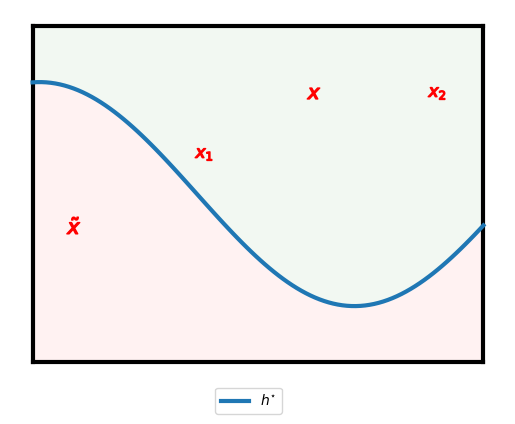

In [22]:
plot_synthetic(corners, reference_points)

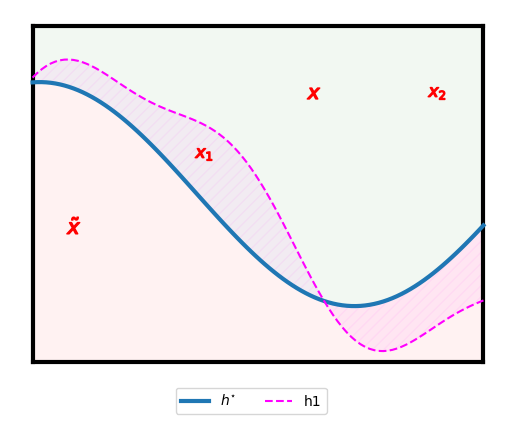

In [23]:
plot_synthetic(corners, reference_points, show_h1=True)

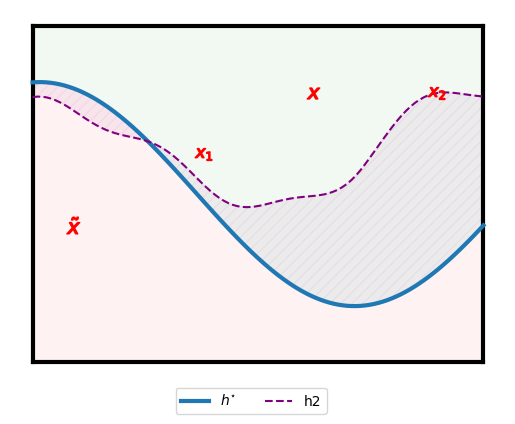

In [24]:
plot_synthetic(corners, reference_points, show_h2=True)

In [25]:
reference_domain = torch.zeros(4,2, device=cuda)
reference_labels = torch.ones(4, device=cuda)

for (index, p) in enumerate(reference_points):
    reference_domain[index] = torch.tensor([reference_points[index][0], reference_points[index][1]])
    
reference_labels = predict_label(h_star, reference_domain)

print(reference_domain)
print(reference_labels)

tensor([[ 3.8000,  0.9000],
        [ 2.7000,  0.3610],
        [ 5.0250,  0.9000],
        [ 1.4000, -0.2760]], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')


In [26]:
num_points = 200
x_val = torch.linspace(x_start, x_end, num_points, device=cuda)
y_val = torch.linspace(y_start, y_end, num_points, device=cuda)

domain = torch.zeros(num_points**2, 2, device=cuda)

for index in range(num_points**2):
    domain[index] = torch.tensor([x_val[index//num_points], y_val[index%num_points]])

true_labels = predict_label(h_star, domain)   

In [27]:
# find subset_domain and subset_labels
from torchmetrics.functional import pairwise_cosine_similarity

In [28]:
a = torch.randn(1000, 784)
b = torch.randn(10, 784)

#b[0] = a[0]

In [29]:
pairwise_cosine_similarity(a, b[:5])

tensor([[-0.0387,  0.0026, -0.0290,  0.0693, -0.0529],
        [-0.0383,  0.0317, -0.0704, -0.0472,  0.0438],
        [-0.0054, -0.0159, -0.0016, -0.0030,  0.0070],
        ...,
        [ 0.0340,  0.0699,  0.0209,  0.0204,  0.0392],
        [ 0.0075,  0.0272, -0.0123, -0.0532, -0.0215],
        [-0.0147, -0.0039,  0.0005, -0.0436, -0.0402]])

In [30]:
c = pairwise_cosine_similarity(a, b[:5])
#d = pairwise_cosine_similarity(a[100:101], b)
#pairwise_cosine_similarity(b, zero_diagonal=False)

print(c.shape)
#print(c[100])
#print(d)

torch.Size([1000, 5])


In [31]:
c

tensor([[-0.0387,  0.0026, -0.0290,  0.0693, -0.0529],
        [-0.0383,  0.0317, -0.0704, -0.0472,  0.0438],
        [-0.0054, -0.0159, -0.0016, -0.0030,  0.0070],
        ...,
        [ 0.0340,  0.0699,  0.0209,  0.0204,  0.0392],
        [ 0.0075,  0.0272, -0.0123, -0.0532, -0.0215],
        [-0.0147, -0.0039,  0.0005, -0.0436, -0.0402]])

In [32]:
e = torch.max(c, dim=1).values
e.shape

torch.Size([1000])

In [33]:
e

tensor([ 6.9284e-02,  4.3833e-02,  6.9970e-03,  6.1951e-02,  4.5694e-02,
         3.2512e-02,  1.8643e-02,  5.8289e-02,  7.8490e-02,  4.1900e-02,
         6.3439e-02,  6.2412e-02,  2.1637e-02,  5.2893e-02,  5.4315e-02,
         1.3612e-02,  8.3135e-02,  6.3824e-02,  3.5378e-02,  5.0136e-02,
         5.8812e-02,  4.5882e-02,  2.0105e-02,  7.3077e-02,  1.9428e-02,
         3.9808e-02,  3.2150e-02,  8.8365e-03,  2.6327e-02,  4.7768e-02,
         6.6229e-02,  1.7743e-02,  9.8777e-02,  3.2334e-02,  4.0193e-02,
         4.7675e-02,  4.0128e-02,  2.5351e-02,  3.7245e-02,  7.2166e-02,
         5.6787e-02,  5.1769e-02,  4.2183e-02,  3.0601e-02,  4.3555e-02,
         4.2498e-02,  5.0300e-02,  6.1794e-02,  6.3663e-02,  3.2903e-02,
         9.1308e-02,  4.8553e-02,  7.2488e-02,  9.4296e-02,  2.7137e-02,
         8.5143e-02,  3.3401e-02,  3.4468e-02,  5.5914e-02,  5.7646e-02,
         2.9912e-02,  2.6686e-02,  1.9241e-02,  4.9926e-03,  6.5693e-02,
         4.5982e-02,  7.1965e-02,  1.9781e-02,  3.8

In [34]:
torch.argmin(e)

tensor(586)

In [35]:
e[torch.argmin(e).item()]

tensor(-0.0347)

In [36]:
torch.mean(e)

tensor(0.0414)

In [37]:
b[1] = a[273]

In [38]:
[10] + list(a.shape)[1:]

[10, 784]

In [39]:
torch.zeros([4,5,6]).shape

torch.Size([4, 5, 6])

In [40]:
true_labels.dtype

torch.int64

In [41]:
len(torch.unique(true_labels))

2

In [42]:
domain[true_labels==1].shape

torch.Size([22591, 2])

In [43]:
true_labels[true_labels==1].shape

torch.Size([22591])

In [44]:
def get_greedy_subset(domain, num_points):
    inp_shape = list(domain.shape)[1:]
    subset_shape = [num_points] + inp_shape
    rand_index = torch.randint(0,len(domain), (1,)).item()
    subset_domain = torch.zeros(subset_shape, device=cuda)
    #subset_labels = torch.zeros(num_points, dtype=torch.int64, device=cuda)
    subset_domain[0] = domain[rand_index]
    
    for index in range(1, num_points):
        sim = pairwise_cosine_similarity(domain, subset_domain[:index])
        max_sim = torch.max(sim, dim=1).values
        selected_index = torch.argmin(max_sim).item()
        subset_domain[index] = domain[selected_index]
        #subset_labels[index] = labels[selected_index]
    return subset_domain #, subset_labels    

In [45]:
def get_greedy_class_subset(domain, true_labels, num_labels, num_points):
    #num_labels = len(torch.unique(true_labels))
    
    subset_domain_class = dict()
    for label in range(num_labels):
        sub_domain = domain[true_labels == label]
        subset_domain_class[label] = get_greedy_subset(sub_domain, num_points//num_labels)
    
    return subset_domain_class    

In [46]:
subset_domain_class = get_greedy_class_subset(domain, true_labels, 2, 100)

In [47]:
subset_domain_class[0].shape

torch.Size([50, 2])

In [48]:
subset_domain = get_greedy_subset(domain, 100)

In [49]:
torch.min(torch.max(pairwise_cosine_similarity(domain, subset_domain), dim=1).values).item()

0.9998895525932312

In [50]:
def plot_subset(corners, subset_domain_class):
    x_left, y_left, x_right, y_right, x_down, y_down, x_up, y_up = generate_data_domain(corners)
    x, y_star, y_1, y_2 = generate_decision_boundary(corners)

    # plot the data domain
    plt.plot(x_left, y_left, color="black", linewidth=3)
    plt.plot(x_right, y_right, color="black", linewidth=3)
    plt.plot(x_down, y_down, color="black", linewidth=3)
    plt.plot(x_up, y_up, color="black", linewidth=3)
    
    # plot true labeling decision boundary 
    plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)
    plt.fill_between(x, y1=y_star, y2=y_down, color="red", alpha=0.05)
    plt.fill_between(x, y1=y_star, y2=y_up, color="green", alpha=0.05)

    for k in subset_domain_class.keys():
        subset_domain = subset_domain_class[k]
        subset_np = subset_domain.cpu().numpy()
        subset_x = [d[0] for d in subset_np]
        subset_y = [d[1] for d in subset_np]
        plt.scatter(subset_x, subset_y, label="subset_" + str(k), s=10)
    
    loc_str = "./greedy_subset_" + str(len(subset_domain)) + ".pdf"
        
    plt.savefig(loc_str, bbox_inches='tight')

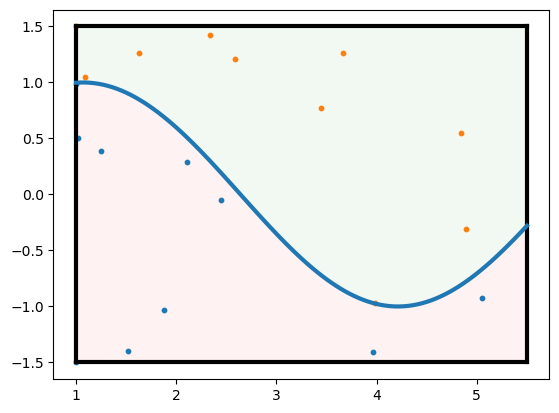

In [51]:
subset_domain_class = get_greedy_class_subset(domain, true_labels, 2, 20)
plot_subset(corners, subset_domain_class)

In [52]:
print(torch.min(torch.max(pairwise_cosine_similarity(domain[true_labels == 0], subset_domain_class[0]), dim=1).values).item())
print(torch.min(torch.max(pairwise_cosine_similarity(domain[true_labels == 1], subset_domain_class[1]), dim=1).values).item())

0.9872272610664368
0.9941263198852539


In [53]:
subset_domain_class_labels = dict()
for k in subset_domain_class.keys():
    subset_domain_class_labels[k] = [k]*len(subset_domain_class[k])

In [54]:
def compute_unsafe_dir(reference_input, reference_label, selected_domain, selected_labels, classifier = None, beta=0.7):
    assert len(selected_domain) == len(selected_labels)
    
    unsafe_dirs = torch.zeros_like(selected_domain)
    unsafe_normalization = torch.ones(len(selected_domain), device=cuda)*float('inf')
    
    for (index, input) in enumerate(selected_domain):
        norm_diff = torch.linalg.norm(input - reference_input, ord=2)
        unsafe_dirs[index] = (input-reference_input)/norm_diff
            
        if selected_labels[index] != reference_label:
            if classifier is not None: 
                # binary search to compute normalization when the true labeling function is given
                low = 0
                high = 1
                while high - low > 1e-5:
                    alpha = (high + low)/2
                    input_alpha = reference_input + alpha*(input-reference_input)
                    label_alpha = predict_label(classifier, input_alpha)
                    if label_alpha == reference_label:
                        low = alpha
                    else:
                        high = alpha
                alpha = low
                input_alpha = reference_input + alpha*(input-reference_input)
                unsafe_normalization[index] = torch.linalg.norm(input_alpha-reference_input, ord=2)
            else:
                unsafe_normalization[index] = norm_diff*beta 
    
    return unsafe_dirs, unsafe_normalization

In [55]:
cpu = torch.device("cpu")
cpu

device(type='cpu')

In [56]:
a = torch.randn(2,device=cuda)
print(a)
a.get_device()

tensor([0.7947, 0.0924], device='cuda:0')


0

In [57]:
b = a.to(device=cpu)
print(b)
b.get_device()

tensor([0.7947, 0.0924])


-1

In [58]:
a

tensor([0.7947, 0.0924], device='cuda:0')

In [59]:
a = float('inf')
a = torch.randn(2,device=cuda)
a.to('cpu')

tensor([2.0002, 0.1193])

In [60]:
b = torch.randn(2)
b.get_device()

-1

In [61]:
def non_isotropic_dist(unsafe_dir, unsafe_normalization, perturbation, dist_type='PL', return_device='cpu', return_type=None):
    if dist_type not in ['PL', 'PD', 'WD']:
        raise ValueError('Non-isotropic distance type should be one of PL, PD, WD')
    
    distance = float('inf')
    
    element_wise_mul = torch.mul(unsafe_dir, perturbation)
    
    if dist_type == 'PL' or dist_type == 'PD':
        scaled_projections = torch.div(torch.sum(element_wise_mul, dim=1), unsafe_normalization)
        if dist_type == 'PL':
            distance = torch.max(torch.clamp(scaled_projections, min=0.0))
        elif dist_type == 'PD':
            distance = torch.max(torch.abs(scaled_projections))
    
    if dist_type == 'WD':
        unsafe_4_norm = torch.linalg.norm(unsafe_dir, dim=1, ord=4)**2 # 4-norm
        modified_normalization = torch.mul(unsafe_normalization, unsafe_4_norm)
        scaled_distances = torch.div(torch.linalg.norm(element_wise_mul, dim=1, ord=2), modified_normalization)
        distance = torch.max(scaled_distances)
    
    distance = distance.detach().to(device=return_device)
    
    if return_type is not None:
        return distance.numpy()
    else:
        return distance

In [62]:
def non_isotropic_projection(unsafe_dir, unsafe_normalization, perturbation, epsilon=1.0, dist_type='PL', num_rounds=3):
    if dist_type not in ['PL', 'PD', 'WD']:
        raise ValueError('Non-isotropic distance type should be one of PL, PD, WD')
    
    if dist_type == 'WD':
        raise ValueError('Projection onto WD currently unsupported')
    
    device = perturbation.get_device()
    scale_flag = False 
    current_perturbation = perturbation 
    
    for t in range(len(num_rounds)):
        for (u, M) in zip(unsafe_dir, unsafe_normalization):
            if dist_type == 'PL' or dist_type == 'PD':
                distance = torch.sum(torch.mul(u, current_perturbation))/M 
                current_perturbation = current_perturbation - (distance-epsilon)*u
                if dist_type == 'PD':
                    distance = torch.sum(torch.mul(-u, current_perturbation))/M
                    current_perturbation = current_perturbation - (distance-epsilon)*(-u)
            else:
                continue 
        
        distance = non_isotropic_dist(unsafe_dir, unsafe_normalization, current_perturbation, dist_type=dist_type, return_device=device, return_type=None)
        if distance <= epsilon:
            break 
    
    distance = non_isotropic_dist(unsafe_dir, unsafe_normalization, current_perturbation, dist_type=dist_type, return_device=device, return_type=None)
    
    if distance > epsilon:
        scale_flag = True
        current_perturbation *= (epsilon/distance)
    
    return current_perturbation, scale_flag

In [63]:
distance_types = ['PL'] #['l2', 'l1', 'linf', 'PL', 'PD', 'WD']

In [64]:
def latexify_dist(dist_type: str):
    if dist_type == 'l2': return r'$\ell_2$'
    elif dist_type == 'linf': return r'$\ell_{\infty}$'
    elif dist_type == 'l1': return r'$\ell_1$'
    else: return dist_type

def latexify_inp(index: int):
    if index == 0: return r'$x$'
    elif index == 1: return r'$x_1$'
    elif index == 2: return r'$x_2$'
    elif index == 3: return r'$\tilde{x}$'
    
def latexify_h(index):
    if index is None: return r'$h^{\star}$'
    elif index == 1: return r'$h_1$'
    elif index == 2: return r'$h_2$'

In [65]:
def get_distances(reference_input, reference_label, domain, true_labels, selected_domain = None, selected_labels = None, classifier = None, dist_type='l2'):
    print("Computing " + dist_type + " distances")
    if dist_type not in distance_types:
        raise ValueError('Distance type should be one of l2, l1, linf, PL, PD, WD')
    
    if selected_domain is not None and selected_labels is not None:
        assert len(selected_domain) == len(selected_labels)
        unsafe_dir, unsafe_normalization = compute_unsafe_dir(reference_input, reference_label, selected_domain, selected_labels, classifier=classifier)
    else:
        unsafe_dir, unsafe_normalization = compute_unsafe_dir(reference_input, reference_label, domain, true_labels, classifier=classifier)        
    
    distances = []
    for (index, input) in enumerate(domain):
        if index % 100 == 0:
            clear_output(wait=True)
            print("Computing distances at index: " + str(index) +  ", out of " + str(len(domain) - 1) + " points.")
        perturbation = input - reference_input
        if dist_type == 'l2':
            distance = torch.linalg.norm(perturbation, ord=2).detach().cpu().numpy()
        elif dist_type == 'l1':
            distance = torch.linalg.norm(perturbation, ord=1).detach().cpu().numpy()
        elif dist_type == 'linf':
            distance = torch.linalg.norm(perturbation, ord=float('inf')).detach().cpu().numpy()
        elif dist_type in ['PL', 'PD', 'WD']:
            distance = non_isotropic_dist(unsafe_dir, unsafe_normalization, perturbation, dist_type)
        distances.append(distance)
    return distances

def sublevel_set(selected_domain, distances, threshold):
    sublevel = []
    for input, distance in zip(selected_domain, distances):
        if distance <= threshold:
            sublevel.append(input.detach().cpu().numpy())
    return sublevel

In [66]:
l_keys = subset_domain_class.keys()
print(len(l_keys))

2


In [67]:
l_keys_list = list(l_keys)

In [68]:
l_keys_list[0]

0

In [69]:
subset_domain_class[l_keys_list[0]].shape

torch.Size([10, 2])

In [70]:
for i in range(2):
    print(i)

0
1


In [71]:
def generate_distances(reference_domain, reference_labels, domain, true_labels, classifier=h_star, distance_types=distance_types, greedy_subset=False, num_points=100):
    selected_domain = None 
    selected_labels = None 
    
    if greedy_subset:
        num_labels = len(torch.unique(true_labels))
        subset_domain_class = get_greedy_class_subset(domain, true_labels, num_labels, num_points)
        inp_shape = list(domain.shape)[1:]
        selected_domain_shape = [num_points] + inp_shape
        selected_domain = torch.zeros(selected_domain_shape, device=cuda)
        selected_labels = torch.ones(num_points, device=cuda)
        label_keys = list(subset_domain_class.keys())
        increment = num_points//num_labels
        for label_index in range(len(label_keys)):
            selected_domain[label_index*increment:(label_index+1)*increment] = subset_domain_class[label_keys[label_index]]
            selected_labels[label_index*increment:(label_index+1)*increment] *= label_keys[label_index]

    distances = dict()
    for dist_type in distance_types:
        if greedy_subset and dist_type not in ['PL', 'PD', 'WD']:
            continue 
                
        for index in range(len(reference_domain)):
            key = "x" + str(index) + "_" + dist_type
            if greedy_subset:
                key += "_greedy_" + str(num_points)
            
            distances[key] = get_distances(reference_domain[index], reference_labels[index], domain, true_labels, selected_domain=selected_domain, selected_labels=selected_labels, classifier=classifier, dist_type=dist_type)
    
    return distances, selected_domain, selected_labels        

In [72]:
distances = generate_distances(
    reference_domain,
    reference_labels,
    domain,
    true_labels,
)

Computing distances at index: 39900, out of 39999 points.


In [208]:
greedy_distances, selected_domain, selected_labels = generate_distances(reference_domain, reference_labels, domain, true_labels, greedy_subset=True, num_points=20)

Computing distances at index: 39900, out of 39999 points.


In [209]:
greedy_distances.keys()

dict_keys(['x0_PL_greedy_20', 'x1_PL_greedy_20', 'x2_PL_greedy_20', 'x3_PL_greedy_20'])

In [73]:
def plot_distance_intensity(
    corners,
    reference_points,
    distances,
    domain,
    selected_domain=None,
    distance_types=distance_types,
    greedy_subset=False,
    num_points=100,
):
    x0, x1, x2, xtil = (
        reference_points[0],
        reference_points[1],
        reference_points[2],
        reference_points[3],
    )
    x_left, y_left, x_right, y_right, x_down, y_down, x_up, y_up = generate_data_domain(
        corners
    )
    x, y_star, y_1, y_2 = generate_decision_boundary(corners)

    domain_np = domain.cpu().numpy()
    domain_x = [d[0] for d in domain_np]
    domain_y = [d[1] for d in domain_np]

    for dist_type in distance_types:
        if greedy_subset and dist_type not in ["PL", "PD", "WD"]:
            continue

        for index in range(len(reference_points)):
            key = "x" + str(index) + "_" + dist_type
            if greedy_subset:
                key += "_greedy_" + str(num_points)
            print(key)
            distance_domain = distances[key]
            plt.figure()
            title_str = latexify_dist(dist_type) + " threat "
            title_str += " from reference point " + latexify_inp(index)
            plt.title(title_str)

            # plot the data domain
            plt.plot(x_left, y_left, color="black", linewidth=3)
            plt.plot(x_right, y_right, color="black", linewidth=3)
            plt.plot(x_down, y_down, color="black", linewidth=3)
            plt.plot(x_up, y_up, color="black", linewidth=3)

            # plot true labeling decision boundary
            plt.plot(x, y_star, label=r"$h^{\star}$", linewidth=3)

            # plot reference points
            plt.plot(x0[0], x0[1], color="black", marker=latexify_inp(0), markersize=9)
            plt.plot(x1[0], x1[1], color="black", marker=latexify_inp(1), markersize=12)
            plt.plot(x2[0], x2[1], color="black", marker=latexify_inp(2), markersize=12)
            plt.plot(
                xtil[0], xtil[1], color="black", marker=latexify_inp(3), markersize=12
            )

            # Plot the distance intensity map
            plt.scatter(domain_x, domain_y, c=distance_domain, s=2, cmap="plasma")
            plt.colorbar(orientation="horizontal")

            if selected_domain is not None:
                selected_np = selected_domain.cpu().numpy()
                selected_x = [d[0] for d in selected_np]
                selected_y = [d[1] for d in selected_np]
                plt.scatter(selected_x, selected_y, color="black", s=5)

            plt.axis("off")
            plt.savefig("./distance_intensity_" + key + ".pdf", bbox_inches="tight")

In [74]:
distances[0].keys()

dict_keys(['x0_PL', 'x1_PL', 'x2_PL', 'x3_PL'])

x0_PL
x1_PL
x2_PL
x3_PL


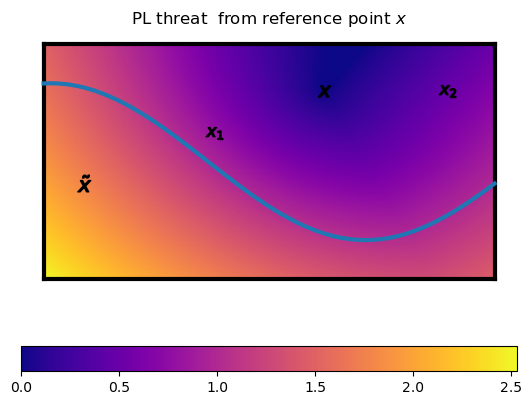

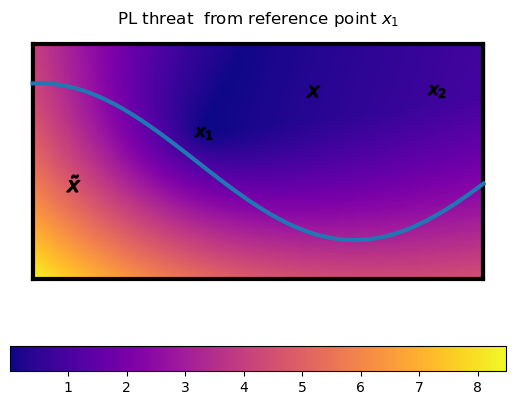

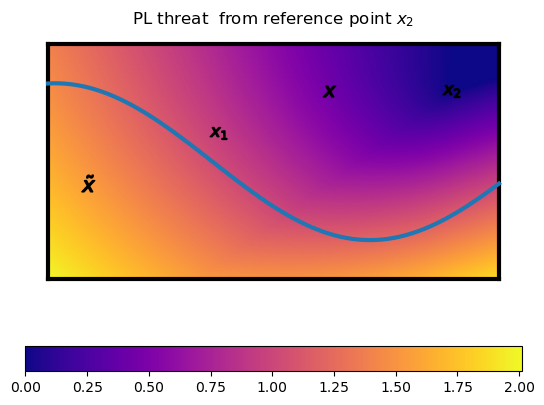

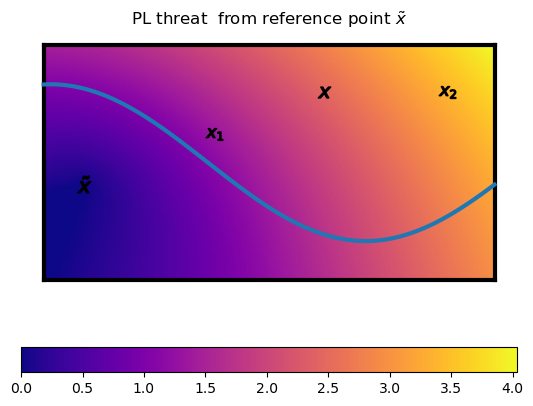

In [77]:
plot_distance_intensity(corners, reference_points, distances[0], domain, selected_domain=None, greedy_subset=False)   

In [90]:
greedy_distances.keys()

dict_keys(['x0_PL_greedy_20', 'x1_PL_greedy_20', 'x2_PL_greedy_20', 'x3_PL_greedy_20'])

In [78]:
# Compute certified threshold for a given point based on its distances matrix and the collection of all points.
def compute_certified_threshold(
    reference_domain, reference_labels, domain, true_labels, distances
):
    certified_thresholds = dict()
    for dist_type in distance_types:
        for r_index in range(len(reference_domain)):
            key = "x" + str(r_index) + "_" + dist_type
            if "_greedy_20" in list(distances.keys())[0]:
                key += "_greedy_20"
            reference_label = reference_labels[r_index]
            threshold = float("inf")
            for index in range(len(domain)):
                if (
                    true_labels[index] != reference_label
                    and threshold > distances[key][index]
                ):
                    threshold = distances[key][index]
            certified_thresholds[key] = threshold
    return certified_thresholds

In [75]:
greedy_distances.keys()

dict_keys(['x0_PL_greedy_20', 'x1_PL_greedy_20', 'x2_PL_greedy_20', 'x3_PL_greedy_20'])

In [79]:
reference_labels_h1 = predict_label(h_1, reference_domain)
reference_labels_h2 = predict_label(h_2, reference_domain)

domain_labels_h1 = predict_label(h_1, domain)
domain_labels_h2 = predict_label(h_2, domain)

certified_thresholds_hstar = compute_certified_threshold(
    reference_domain, reference_labels, domain, true_labels, distances[0]
)
certified_thresholds_h1 = compute_certified_threshold(
    reference_domain, reference_labels_h1, domain, domain_labels_h1, distances[0]
)
certified_thresholds_h2 = compute_certified_threshold(
    reference_domain, reference_labels_h2, domain, domain_labels_h2, distances[0]
)

In [212]:
greedy_certified_thresholds_hstar = compute_certified_threshold(
    reference_domain, reference_labels, domain, true_labels, greedy_distances
)
greedy_certified_thresholds_h1 = compute_certified_threshold(
    reference_domain, reference_labels_h1, domain, domain_labels_h1, greedy_distances
)
greedy_certified_thresholds_h2 = compute_certified_threshold(
    reference_domain, reference_labels_h2, domain, domain_labels_h2, greedy_distances
)

In [80]:
str(certified_thresholds_hstar['x0_PL'])

'tensor(1.0008)'

In [81]:
latexify_h(None)

'$h^{\\star}$'

In [82]:
latexify_dist('l2')

'$\\ell_2$'

In [83]:
distances[0].keys()

dict_keys(['x0_PL', 'x1_PL', 'x2_PL', 'x3_PL'])

In [84]:
len(distances[0]['x2_PL'])

40000

In [85]:
for key in distances[0].keys():
    for (index, val) in enumerate(distances[0][key]):
        if val == 0.0:
            distances[0][key][index] = 0.0
        else:
            distances[0][key][index] = distances[0][key][index].item()

In [213]:
for key in greedy_distances.keys():
    for (index, val) in enumerate(greedy_distances[key]):
        if val == 0.0:
            greedy_distances[key][index] = 0.0
        else:
            greedy_distances[key][index] = greedy_distances[key][index].item()

In [86]:
vals = np.array(distances[0]['x2_PL'])
print(len(vals))
print(len(vals[vals < 0.0]))
print(len(vals[vals == 0.0]))
print(len(vals[vals > 0.0]))

40000
0
710
39290


In [87]:
latexify_inp(0)

'$x$'

In [88]:
from matplotlib import colormaps

In [89]:
def plot_sublevel_sets(
    corners,
    reference_points,
    distances,
    domain,
    certified_thresholds,
    selected_domain=None,
    distance_types=distance_types,
    h_index=None,
):
    x0, x1, x2, xtil = (
        reference_points[0],
        reference_points[1],
        reference_points[2],
        reference_points[3],
    )
    x_left, y_left, x_right, y_right, x_down, y_down, x_up, y_up = generate_data_domain(
        corners
    )
    x, y_star, y_1, y_2 = generate_decision_boundary(corners)
    h_str = "h" + str(h_index) if h_index is not None else "hstar"

    domain_np = domain.cpu().numpy()
    domain_x = [d[0] for d in domain_np]
    domain_y = [d[1] for d in domain_np]
    file_names = []
    for dist_type in distance_types:
        for index in range(len(reference_points)):
            # if index == 1 or index == 2: continue
            key = "x" + str(index) + "_" + dist_type
            if "_greedy_20" in list(distances.keys())[0]:
                key += "_greedy_20"

            distance_domain = distances[key]
            certified_threshold = certified_thresholds[key]
            cert_str = "%.2f" % certified_threshold
            title_str = (
                latexify_dist(dist_type)
                + " certified threshold for "
                + latexify_h(h_index)
                + " at "
                + latexify_inp(index)
                + " is "
                + cert_str
            )
            plt.figure()
            # plt.title(title_str)

            # plot the data domain
            plt.plot(x_left, y_left, color="black", linewidth=3)
            plt.plot(x_right, y_right, color="black", linewidth=3)
            plt.plot(x_down, y_down, color="black", linewidth=3)
            plt.plot(x_up, y_up, color="black", linewidth=3)

            # plot true labeling decision boundary
            plt.plot(x, y_star, label=r"$h^{\star}$", linewidth=3)
            plt.fill_between(x, y1=y_star, y2=y_down, color="red", alpha=0.05)
            plt.fill_between(x, y1=y_star, y2=y_up, color="green", alpha=0.05)

            # plot selected domain if given
            if selected_domain is not None:
                selected_np = selected_domain.cpu().numpy()
                selected_x = [d[0] for d in selected_np]
                selected_y = [d[1] for d in selected_np]
                plt.scatter(selected_x, selected_y, color="blue", s=30, marker="v")

            if h_index == 1:
                plt.plot(
                    x, y_1, color="magenta", label=latexify(h_index), linestyle="dashed"
                )
                plt.fill_between(
                    x, y1=y_1, y2=y_star, color="magenta", alpha=0.05, hatch="///"
                )
            elif h_index == 2:
                plt.plot(
                    x, y_2, color="purple", label=latexify(h_index), linestyle="dashed"
                )
                plt.fill_between(
                    x, y1=y_2, y2=y_star, color="purple", alpha=0.05, hatch="///"
                )

            # plot reference points
            plt.plot(x0[0], x0[1], color="black", marker=r"$x$", markersize=9)
            plt.plot(x1[0], x1[1], color="black", marker=r"$x_1$", markersize=12)
            plt.plot(x2[0], x2[1], color="black", marker=r"$x_2$", markersize=12)
            plt.plot(
                xtil[0], xtil[1], color="black", marker=r"$\tilde{x}$", markersize=12
            )

            print("\n Starting sublevel set plot for input " + latexify_inp(index))
            # cm = plt.cm.get_cmap("Reds") #Oranges
            cm = plt.cm.get_cmap("autumn")
            # #max_eps = 1.0eps * (1 - 0.1 / (0.1 + eps))
            epsilons = np.linspace(0, certified_threshold, 10)
            print(epsilons)
            prev_sublevel = None
            # # Plot the sublevel sets upto certified threshold
            sublevel = sublevel_set(domain, distance_domain, certified_threshold)
            sublevel_x = [d[0] for d in sublevel]
            sublevel_y = [d[1] for d in sublevel]
            plt.scatter(
                sublevel_x,
                sublevel_y,
                alpha=1.0,
                c=cm(1 - 1e-1),
                s=1.0,
            )

            for (index, eps) in enumerate(epsilons):
                current_sublevel = sublevel_set(domain, distance_domain, eps)
                mask = [True] * len(current_sublevel)
                if prev_sublevel is not None:
                    for i in range(len(current_sublevel)):
                        mask[i] = not np.any(
                            np.all(prev_sublevel == current_sublevel[i], axis=1)
                        )

                #                        mask[i] = not any(np.array_equal(current_sublevel[i], arr) for arr in prev_sublevel)
                # if current_sublevel[i] in prev_sublevel:
                #     mask[i] = False

                # Get elements from the list where the mask is True
                filtered_sublevel = [
                    item for item, m in zip(current_sublevel, mask) if m
                ]
                print(
                    "At eps = "
                    + str(eps)
                    + ", ratio of filtered sublevel/current_sublevel = "
                    + str(len(filtered_sublevel))
                    + "/"
                    + str(len(current_sublevel))
                )

                sublevel_x = [d[0] for d in filtered_sublevel]
                sublevel_y = [d[1] for d in filtered_sublevel]
                plt.scatter(
                    sublevel_x,
                    sublevel_y,
                    alpha=1.0,  # 0.5,
                    c=cm(1 - 1e-1 - eps / 1.5),  # "orange",
                    s=eps,
                )

                # Stack all arrays into one 2D array
                if len(current_sublevel) > 0:
                    prev_sublevel = np.stack(current_sublevel)
                else:
                    prev_sublevel = None
            file_name = "./certified threshold_" + h_str + key + ".pdf"

            plt.axis("off")
            plt.savefig(file_name, bbox_inches="tight")
            file_names.append(file_name)

    print(file_names)


 Starting sublevel set plot for input $x$
[0.         0.11120117 0.22240233 0.3336035  0.44480467 0.55600584
 0.667207   0.77840817 0.88960934 1.0008105 ]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.0, ratio of filtered sublevel/current_sublevel = 362/362


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.11120116710662842, ratio of filtered sublevel/current_sublevel = 1137/1499
At eps = 0.22240233421325684, ratio of filtered sublevel/current_sublevel = 1433/2932


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.33360350131988525, ratio of filtered sublevel/current_sublevel = 1796/4728


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.44480466842651367, ratio of filtered sublevel/current_sublevel = 2161/6889


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.5560058355331421, ratio of filtered sublevel/current_sublevel = 2491/9380


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.6672070026397705, ratio of filtered sublevel/current_sublevel = 2589/11969


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.7784081697463989, ratio of filtered sublevel/current_sublevel = 2626/14595


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.8896093368530273, ratio of filtered sublevel/current_sublevel = 2666/17261


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 1.0008105039596558, ratio of filtered sublevel/current_sublevel = 2734/19995

 Starting sublevel set plot for input $x_1$
[0.         0.11255299 0.22510597 0.33765896 0.45021195 0.56276494
 0.67531792 0.78787091 0.9004239  1.01297688]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

At eps = 0.0, ratio of filtered sublevel/current_sublevel = 0/0
At eps = 0.11255298720465766, ratio of filtered sublevel/current_sublevel = 1123/1123
At eps = 0.22510597440931532, ratio of filtered sublevel/current_sublevel = 1488/2611


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.33765896161397296, ratio of filtered sublevel/current_sublevel = 1463/4074


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.45021194881863064, ratio of filtered sublevel/current_sublevel = 1461/5535


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.5627649360232883, ratio of filtered sublevel/current_sublevel = 1466/7001


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.6753179232279459, ratio of filtered sublevel/current_sublevel = 1478/8479


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.7878709104326036, ratio of filtered sublevel/current_sublevel = 1499/9978


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.9004238976372613, ratio of filtered sublevel/current_sublevel = 1446/11424


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 1.012976884841919, ratio of filtered sublevel/current_sublevel = 917/12341

 Starting sublevel set plot for input $x_2$
[0.         0.11210064 0.22420128 0.33630192 0.44840256 0.5605032
 0.67260385 0.78470449 0.89680513 1.00890577]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.0, ratio of filtered sublevel/current_sublevel = 710/710
At eps = 0.11210064093271892, ratio of filtered sublevel/current_sublevel = 1019/1729


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.22420128186543783, ratio of filtered sublevel/current_sublevel = 1188/2917


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.33630192279815674, ratio of filtered sublevel/current_sublevel = 1428/4345


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.44840256373087567, ratio of filtered sublevel/current_sublevel = 1676/6021


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.5605032046635946, ratio of filtered sublevel/current_sublevel = 1928/7949


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.6726038455963135, ratio of filtered sublevel/current_sublevel = 2184/10133


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.7847044865290325, ratio of filtered sublevel/current_sublevel = 2445/12578


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.8968051274617513, ratio of filtered sublevel/current_sublevel = 2698/15276


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 1.0089057683944702, ratio of filtered sublevel/current_sublevel = 2952/18228

 Starting sublevel set plot for input $\tilde{x}$
[0.         0.11125052 0.22250104 0.33375156 0.44500208 0.5562526
 0.66750312 0.77875364 0.89000416 1.00125468]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.0, ratio of filtered sublevel/current_sublevel = 808/808


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.11125051975250244, ratio of filtered sublevel/current_sublevel = 1149/1957
At eps = 0.22250103950500488, ratio of filtered sublevel/current_sublevel = 1035/2992


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.3337515592575073, ratio of filtered sublevel/current_sublevel = 1019/4011


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.44500207901000977, ratio of filtered sublevel/current_sublevel = 1033/5044


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.5562525987625122, ratio of filtered sublevel/current_sublevel = 1064/6108


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.6675031185150146, ratio of filtered sublevel/current_sublevel = 1120/7228


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.7787536382675171, ratio of filtered sublevel/current_sublevel = 1170/8398


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 0.8900041580200195, ratio of filtered sublevel/current_sublevel = 1234/9632


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


At eps = 1.001254677772522, ratio of filtered sublevel/current_sublevel = 1287/10919
['./certified threshold_hstarx0_PL.pdf', './certified threshold_hstarx1_PL.pdf', './certified threshold_hstarx2_PL.pdf', './certified threshold_hstarx3_PL.pdf']


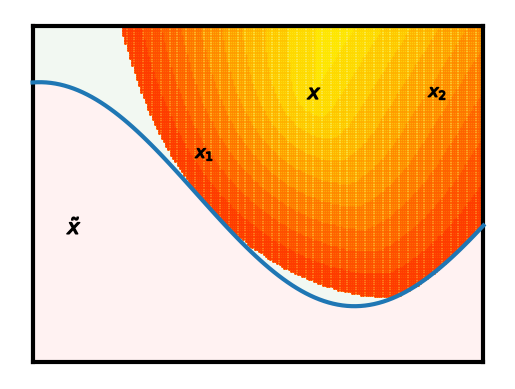

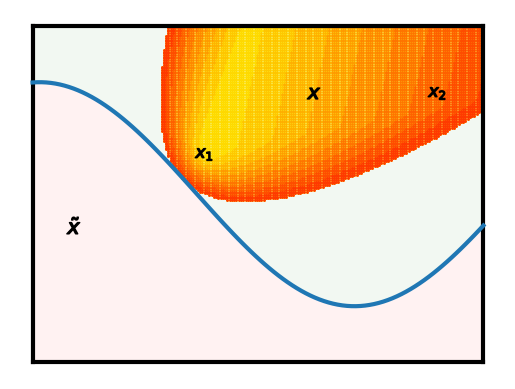

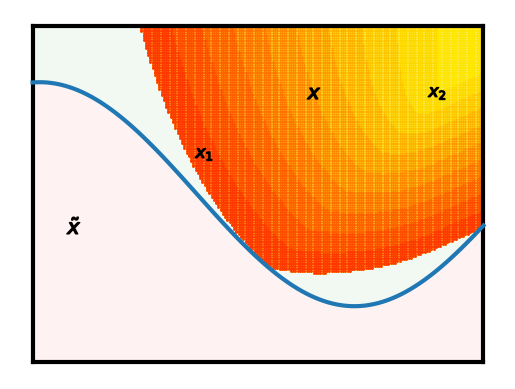

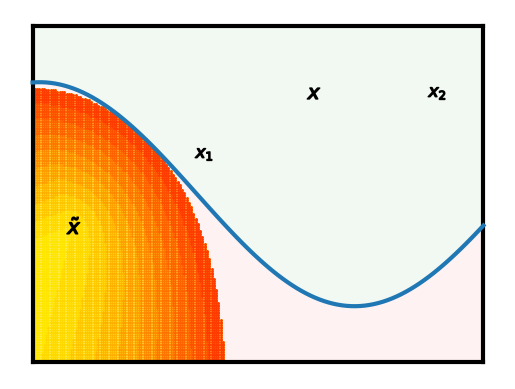

In [93]:
plot_sublevel_sets(
    corners,
    reference_points,
    distances[0],
    domain,
    certified_thresholds_hstar,
    selected_domain=None, #selected_domain,
    h_index=None,
)

In [228]:
len(selected_domain)

20

In [ ]:
plot_sublevel_sets(
    corners,
    reference_points,
    greedy_distances,
    domain,
    certified_thresholds_h1,
    h_index=1,
)

plot_sublevel_sets(
    corners,
    reference_points,
    greedy_distances,
    domain,
    certified_thresholds_h2,
    h_index=2,
)

In [217]:
greedy_certified_thresholds_hstar

{'x0_PL_greedy_20': tensor(0.8724),
 'x1_PL_greedy_20': tensor(1.0120),
 'x2_PL_greedy_20': tensor(0.4694),
 'x3_PL_greedy_20': tensor(0.9734)}

In [ ]:
# unsafe_dir, unsafe_normalization = compute_unsafe_dir(p_ref, domain)
# unsafe_pert = []
# for d in unsafe_dir:
#     unsafe_pert.append(sum(p_ref, d))

# unsafe_pert_x = [d.x for d in unsafe_pert]
# unsafe_pert_y = [d.y for d in unsafe_pert]


# sublevel_PL = sublevel_set(domain, distance_domain_PL, 0.0)

# sublevel_PL_x = [d.x for d in sublevel_PL]
# sublevel_PL_y = [d.y for d in sublevel_PL]


# plt.scatter(sublevel_PL_x, sublevel_PL_y, c='green', s=0.1)
# plt.scatter(unsafe_pert_x, unsafe_pert_y, c='red', s=0.1)
# #plt.plot([3.8],[0.9], color='black', marker=r'$x$', markersize=9)
# #plt.plot([2.7],[0.361], color='red', marker=r'$x_1$', markersize=12)
# #plt.plot([1.4],[-0.276], color='red', marker=r'$\tilde{x}$', markersize=12)
# plt.plot([4.94],[0.452], color='red', marker=r'$x_2$', markersize=12)
# plt.plot(x, y, color="black", label="h*", linewidth=3)
# plt.plot(x1,y1, color="black", linewidth=3)
# plt.plot(x2,y2, color="black", linewidth=3)
# plt.plot(x3,y3, color="black", linewidth=3)
# plt.plot(x4,y4, color="black", linewidth=3)
# plt.axis('off')
# plt.title("x + Unsafe Directions")